This Notebook demonstrates the implementation of PINNs for solving the Navier Stokes equation, Using both DeepXDE and Tensorflow we start by importing required Libraries

In [1]:
import numpy as np 
import deepxde as dde
import matplotlib.pyplot as plt
from scipy.io import loadmat
import re
import os

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term


We define Parameters for the navier stokes equation C1 and C2 represent convective coefficient and viscocity coeffecient, the parameters are assumed to be unknown and will be learned during training to better fit the data

In [2]:
C1true = 1.0
C2true = 0.01

We define a function to generate set of data points such that it could contain velocity and time data for corresponding coordinates which will be extracted from the matfile

In [9]:

import scipy 

def load_training_data(num):
    data = scipy.io.loadmat("/Users/soham/.vscode/OrbitInterpolationAlgo/cylinder_nektar_wake.mat")
    U_star = data["U_star"]  
    P_star = data["p_star"]  
    t_star = data["t"]  
    X_star = data["X_star"] # both x and y coordinates 
    N = X_star.shape[0] # total number of spatial points
    T = t_star.shape[0] # total number of time steps

    XX = np.tile(X_star[:, 0:1], (1, T))  # replicates the array T times 
    YY = np.tile(X_star[:, 1:2], (1, T))  
    TT = np.tile(t_star, (1, N)).T  
    UU = U_star[:, 0, :]  
    VV = U_star[:, 1, :]  
    PP = P_star  
    x = XX.flatten()[:, None]  
    y = YY.flatten()[:, None]  
    t = TT.flatten()[:, None]  
    u = UU.flatten()[:, None]  
    v = VV.flatten()[:, None]  
    p = PP.flatten()[:, None]  

    data1 = np.concatenate([x, y, t, u, v, p], 1) 
    data2 = data1[data1[:, 2] <= 7] 
    data3 = data2[data2[:, 0] >= 1]
    data4 = data3[data3[:, 0] <= 8]
    data5 = data4[data4[:, 1] >= -2]
    data_domain = data5[data5[:, 1] <= 2]
    
    idx = np.random.choice(data_domain.shape[0], num, replace=False) 
    x_train = data_domain[idx, 0:1] # extract random points for training
    y_train = data_domain[idx, 1:2]
    t_train = data_domain[idx, 2:3]
    u_train = data_domain[idx, 3:4]
    v_train = data_domain[idx, 4:5]
    p_train = data_domain[idx, 5:6]
    
    return [x_train, y_train, t_train, u_train, v_train, p_train]

In [5]:
C1 = dde.Variable(0.0)
C2 = dde.Variable(0.0)

In [7]:
def NS(x, y): # we define Navier Stokes as governing equation 
    u = y[:, 0:1]
    v = y[:, 1:2]
    p = y[:, 2:3]
    du_x = dde.grad.jacobian(y, x, i=0, j=0)
    du_y = dde.grad.jacobian(y, x, i=0, j=1)
    du_t = dde.grad.jacobian(y, x, i=0, j=2)
    dv_x = dde.grad.jacobian(y, x, i=1, j=0)
    dv_y = dde.grad.jacobian(y, x, i=1, j=1)
    dv_t = dde.grad.jacobian(y, x, i=1, j=2)
    dp_x = dde.grad.jacobian(y, x, i=2, j=0)
    dp_y = dde.grad.jacobian(y, x, i=2, j=1)
    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)
    continuity = du_x + dv_y
    x_momentum = du_t + C1 * (u * du_x + v * du_y) + dp_x - C2 * (du_xx + du_yy)
    y_momentum = dv_t + C1 * (u * dv_x + v * dv_y) + dp_y - C2 * (dv_xx + dv_yy)
    return [continuity, x_momentum, y_momentum]

In [6]:
Lx_min, Lx_max = 1.0, 8.0
Ly_min, Ly_max = -2.0, 2.0
space_domain = dde.geometry.Rectangle([Lx_min, Ly_min], [Lx_max, Ly_max])
time_domain = dde.geometry.TimeDomain(0, 7)
geom_disk = dde.geometry.Disk([4, 4], 1)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

In [10]:
[ob_x, ob_y, ob_t, ob_u, ob_v, ob_p] = load_training_data(num=7000)
ob_xyt = np.hstack((ob_x, ob_y, ob_t))
num_points = 7000  
radius = 1.0  
center = (4.0, 1.0) 

angles = np.linspace(0, 2 * np.pi, num_points) 
radii = np.sqrt(np.random.rand(num_points)) * radius  
x = radii * np.cos(angles) + center[0]
y = radii * np.sin(angles) + center[1]
t = np.zeros_like(x)  

observe_u = dde.icbc.PointSetBC(ob_xyt, ob_u, component=0)
observe_v = dde.icbc.PointSetBC(ob_xyt, ob_v, component=1)


data = dde.data.TimePDE(
    geomtime,
    NS,
    [observe_u, observe_v],
    num_domain=700,
    num_boundary=200,
    num_initial=100,
    anchors=ob_xyt,
)

layer_size = [3] + [50] * 6 + [3]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)

fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue([C1, C2], period=100, filename=fnamevar)



In [11]:
model.compile("adam", lr=1e-3, external_trainable_variables=[C1, C2])
loss_history, train_state = model.train(
    iterations=1000, callbacks=[variable], display_every=100, disregard_previous_best=True
)
model.compile("adam", lr=1e-4, external_trainable_variables=[C1, C2])
loss_history, train_state = model.train(
    iterations=1000, callbacks=[variable], display_every=100, disregard_previous_best=True
)
model.save("source_model")

Compiling model...
Building feed-forward neural network...
'build' took 0.061796 s


'compile' took 1.147263 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [2.39e-03, 2.11e-03, 6.95e-03, 1.28e+00, 1.50e-01]    [2.39e-03, 2.11e-03, 6.95e-03, 1.28e+00, 1.50e-01]    []  
100       [6.53e-04, 2.61e-04, 4.21e-04, 7.70e-02, 6.83e-02]    [6.53e-04, 2.61e-04, 4.21e-04, 7.70e-02, 6.83e-02]    []  
200       [7.51e-04, 8.85e-04, 1.98e-03, 3.87e-02, 5.88e-02]    [7.51e-04, 8.85e-04, 1.98e-03, 3.87e-02, 5.88e-02]    []  
300       [1.17e-03, 1.48e-03, 7.39e-03, 2.41e-02, 3.38e-02]    [1.17e-03, 1.48e-03, 7.39e-03, 2.41e-02, 3.38e-02]    []  
400       [9.22e-04, 2.01e-03, 5.99e-03, 1.51e-02, 2.31e-02]    [9.22e-04, 2.01e-03, 5.99e-03, 1.51e-02, 2.31e-02]    []  
500       [7.12e-04, 2.17e-03, 3.99e-03, 9.31e-03, 1.71e-02]    [7.12e-04, 2.17e-03, 3.99e-03, 9.31e-03, 1.71e-02]    []  
6

'source_model-2000.ckpt'

C:\Users\soham\AppData\Local\Temp\ipykernel_12400\3117164625.py:53: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


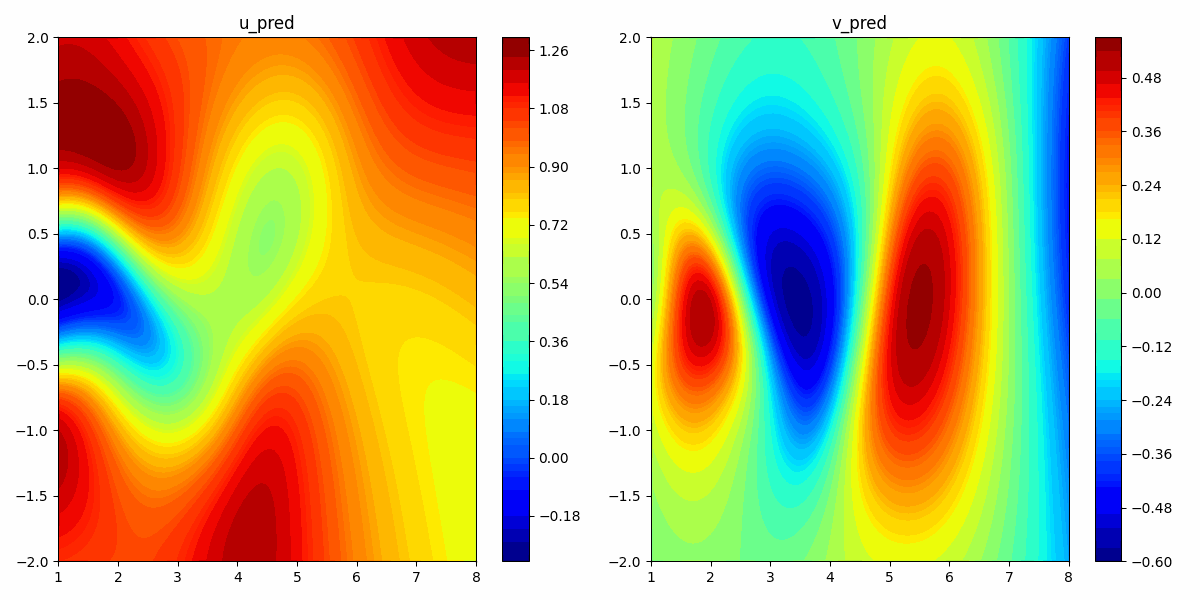

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from IPython.display import Image
from scipy.interpolate import griddata

output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

filenames = []

for t in range(0, 8):
    [ob_x, ob_y, ob_t, ob_u, ob_v, ob_p] = load_training_data(num=140000)
    xyt_pred = np.hstack((ob_x, ob_y, t * np.ones((len(ob_x), 1))))
    uvp_pred = model.predict(xyt_pred)
    x_pred, y_pred, t_pred = xyt_pred[:, 0], xyt_pred[:, 1], xyt_pred[:, 2]
    u_pred, v_pred, p_pred = uvp_pred[:, 0], uvp_pred[:, 1], uvp_pred[:, 2]

    grid_x, grid_y = np.meshgrid(np.linspace(x_pred.min(), x_pred.max(), 100),
                                np.linspace(y_pred.min(), y_pred.max(), 100))
    # Interpolate u_pred onto the grid using griddata
    u_grid = griddata((x_pred, y_pred), u_pred, (grid_x, grid_y), method='cubic')
    v_grid = griddata((x_pred, y_pred), v_pred, (grid_x, grid_y), method='cubic')

    # Plot the results
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot u_pred
    cntr0 = axs[0].contourf(grid_x, grid_y, u_grid, levels=80, cmap="jet")
    axs[0].set_title("u_pred")
    fig.colorbar(cntr0, ax=axs[0])

    # Plot v_pred
    cntr1 = axs[1].contourf(grid_x, grid_y, v_grid, levels=80, cmap="jet")
    axs[1].set_title("v_pred")
    fig.colorbar(cntr1, ax=axs[1])
    plt.tight_layout()
    # Save the current frame
    filename = os.path.join(output_dir, f"temp_frame_{t}.png")
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()

gif_filename = 'velocity_heatmap_animation.gif'
with imageio.get_writer(gif_filename, mode='I', duration=0.5) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

for filename in filenames:
    os.remove(filename)

Image(filename=gif_filename)

Inverse model in Tensorflow

In [18]:
import numpy as np
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from keras.activations import *


In [28]:
class PINN(tf.keras.Model):
    def __init__(self, layer_sizes, activation):
        super(PINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(size, activation=activation) for size in layer_sizes[:-1]]
        self.output_layer = tf.keras.layers.Dense(layer_sizes[-1])

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)
    
layer_sizes = [3] + [50] * 6 + [3]
activation = "tanh"
model = PINN(layer_sizes, activation) 
C1 = tf.Variable(initial_value=1.0, dtype=tf.float32, trainable=True)
C2 = tf.Variable(initial_value=0.01, dtype=tf.float32, trainable=True)


In [33]:
def loss_function(model, x, y, t, u, v, p, C1, C2):
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.float32)
    u = tf.cast(u, dtype=tf.float32)
    v = tf.cast(v, dtype=tf.float32)
    p = tf.cast(p, dtype=tf.float32)
    t = tf.cast(t, dtype=tf.float32)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(y)
        tape.watch(t)
        inputs = tf.concat([x, y, t], axis=1)
        outputs = model(inputs)
        u_pred = outputs[:, 0:1]
        v_pred = outputs[:, 1:2]
        p_pred = outputs[:, 2:3]

        du_x = tape.gradient(u_pred, x)
        du_y = tape.gradient(u_pred, y)
        du_t = tape.gradient(u_pred, t)
        dv_x = tape.gradient(v_pred, x)
        dv_y = tape.gradient(v_pred, y)
        dv_t = tape.gradient(v_pred, t)
        dp_x = tape.gradient(p_pred, x)
        dp_y = tape.gradient(p_pred, y)
        du_xx = tape.gradient(du_x, x)
        du_yy = tape.gradient(du_y, y)
        dv_xx = tape.gradient(dv_x, x)
        dv_yy = tape.gradient(dv_y, y)

        continuity = du_x + dv_y
        x_momentum = du_t + C1 * (u_pred * du_x + v_pred * du_y) + dp_x - C2 * (du_xx + du_yy)
        y_momentum = dv_t + C1 * (u_pred * dv_x + v_pred * dv_y) + dp_y - C2 * (dv_xx + dv_yy)

    loss = tf.reduce_mean(tf.square(continuity)) + tf.reduce_mean(tf.square(x_momentum)) + tf.reduce_mean(tf.square(y_momentum))
    return loss

def train(model, x_train, y_train, t_train, u_train, v_train, p_train, C1, C2, epochs, learning_rate):
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss = loss_function(model, x_train, y_train, t_train, u_train, v_train, p_train, C1, C2)
        gradients = tape.gradient(loss, model.trainable_variables + [C1, C2])
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))


x_train, y_train, t_train, u_train, v_train, p_train = load_training_data(num=7000)
train(model, x_train, y_train, t_train, u_train, v_train, p_train, C1, C2, epochs=10, learning_rate=1e-3)
